In [1]:
from pathlib import Path
import warnings

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.utils import aggregate
from lightgbm import LGBMRegressor
from loguru import logger
import matplotlib.pyplot as plt
from mlforecast import MLForecast
import pandas as pd
import polars as pl
import typer
from datetime import datetime

from valuation.asset.identity.dataset import DatasetID
from valuation.asset.identity.model import ModelPassport
from valuation.asset.model.mlforecast import MLForecastModel
from valuation.core.stage import DatasetStage
from valuation.flow.modeling.model_selection.base import ModelParams
from valuation.flow.modeling.model_selection.light_gbm import LightGBMHP
from valuation.flow.modeling.model_selection.mlforecast import MLForecastHP
from valuation.infra.loggers import configure_logging
from valuation.infra.store.dataset import DatasetStore
from valuation.infra.store.model import ModelStore
import wandb
from wandb import sdk

/home/john/anaconda3/envs/valuation/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/john/anaconda3/envs/valuation/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened b

In [2]:
# ------------------------------------------------------------------------------------------------ #
# Suppress warnings
warnings.filterwarnings("ignore", message=".*lag.*")
warnings.filterwarnings("ignore", message=".*UnsupportedFieldAttributeWarning.*")
# ------------------------------------------------------------------------------------------------ #
app = typer.Typer()
run = wandb.init(project="valuation", job_type="final_training", name="5year_forecast")
# ------------------------------------------------------------------------------------------------ #
FORECAST_HORIZON = 260  # 52 weeks/year * 5 years
FORECAST_FILEPATH = f"report/forecasts_5year_1997_2002{datetime.now().strftime("%Y-%m-%d_%h-%m-%s")}.csv"

wandb: Currently logged in as: aistudio to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load Dataset

In [3]:
def load_dataset():
    full_train_df = pd.read_parquet("data/prod/train/dataset_train_sales_full.parquet")
    logger.info(f"\nFull training dataset loaded:")
    logger.info(f"  Shape: {full_train_df.shape}")
    logger.info(f"  Unique series: {full_train_df['unique_id'].nunique()}")
    logger.info(f"  Date range: {full_train_df['ds'].min()} to {full_train_df['ds'].max()}")
    logger.info(
        f"  Revenue range: [{full_train_df['y'].min():.2f}, {full_train_df['y'].max():.2f}]"
    )
    logger.info(f"  Revenue mean: {full_train_df['y'].mean():.2f}")
    return full_train_df

## Full Train

In [4]:
def full_train(full_train_df: pd.DataFrame) -> MLForecast:
    # ============================================================================
    # 2. MODEL PARAMETERS (Same as cross-validation)
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("MODEL PARAMETERS")
    logger.info("=" * 80)

    NUM_CORES = 24
    RANDOM_STATE = 42

    # LightGBM model parameters
    lightgbm_params = LightGBMHP(
        objective="tweedie",
        tweedie_variance_power=1.2,
        n_estimators=1000,
        learning_rate=0.02,
        reg_alpha=1.0,
        reg_lambda=1.0,
        subsample=0.8,
        max_depth=7,
        boost_from_average=False,
    )

    # MLForecast parameters
    mlforecast_params = MLForecastHP(
        lags=[1, 2, 4, 13, 52, 43],
    )

    # Combine all model parameters
    model_params = ModelParams(
        light_gbm=lightgbm_params,
        mlforecast=mlforecast_params,
        cross_validation=None,  # Not needed for final training
    )

    logger.info(f"\nModel: LightGBM Regressor")
    logger.info(f"  Objective: {lightgbm_params.objective}")
    logger.info(f"  Tweedie variance power: {lightgbm_params.tweedie_variance_power}")
    logger.info(f"  Lags: {mlforecast_params.lags}")

    # ============================================================================
    # 3. INITIALIZE WANDB FOR TRACKING
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("INITIALIZING EXPERIMENT TRACKING")
    logger.info("=" * 80)

    run.config.update(lightgbm_params.as_dict())
    run.config.update(mlforecast_params.as_dict())
    run.config.update({"forecast_horizon": 260, "forecast_years": 5})  # 52 weeks * 5 years

    # ============================================================================
    # 4. CREATE AND FIT THE MODEL
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("TRAINING MODEL ON FULL DATASET")
    logger.info("=" * 80)

    # Instantiate the LightGBM model
    models = [LGBMRegressor(**lightgbm_params.as_dict())]

    # Create MLForecast instance
    mf = MLForecast(models=models, **mlforecast_params.as_dict())

    # Fit on the full training dataset
    logger.info("\nFitting model...")
    mf.fit(df=full_train_df)
    logger.info("âœ… Model training complete!")
    return mf

## Load Model


In [5]:
import joblib
from mlforecast import MLForecast # Import the main class definition
from valuation.flow.modeling.model_selection.light_gbm import LightGBMHP
from valuation.flow.modeling.model_selection.mlforecast import MLForecastHP
# Assuming your two model files are named model_A.pkl and model_B.pkl

# Load the first model
try:
    model_a =   joblib.load('model/prod/final/lightgbm_model_with_tweedie_variance_power_1.2/models.pkl')
    print(f"✅ Model A loaded successfully. Type: {type(model_a)}")
except FileNotFoundError:
    print("❌ Error: model_A.pkl not found. Check the path.")
except Exception as e:
    print(f"❌ Error loading Model A: {e}")

# Load the second model
try:
    model_b = joblib.load('model/prod/final/lightgbm_model_100_trees.json/models.pkl')
    print(f"✅ Model B loaded successfully. Type: {type(model_b)}")
except FileNotFoundError:
    print("❌ Error: model_B.pkl not found. Check the path.")
except Exception as e:
    print(f"❌ Error loading Model B: {e}")

# --- 2. Define the MLForecast parameters used in the original training ---
# (Grab these from the full_train function)
mlforecast_params = MLForecastHP(lags=[1, 2, 4, 13, 52, 43])

✅ Model A loaded successfully. Type: <class 'dict'>
✅ Model B loaded successfully. Type: <class 'dict'>


## Generate 5 Year Forecast

In [6]:
def generate_forecast(mf: MLForecast, full_train_df: pd.DataFrame) -> pd.DataFrame:
    # ============================================================================
    # 5. GENERATE 5-YEAR FORECAST (260 weeks)
    # ============================================================================
     # Identify forecast column (model name)
    forecast_col = "LGBMRegressor"
    logger.info("\n" + "=" * 80)
    logger.info("GENERATING 5-YEAR FORECAST (1997-2002)")
    logger.info("=" * 80)

    logger.info(f"\nForecasting {FORECAST_HORIZON} weeks ahead...")
    forecast_df = mf.predict(h=FORECAST_HORIZON)
    # Add Noon-Negative Constraint
    forecast_df[forecast_col] = forecast_df[forecast_col].clip(lower=0)

    logger.info(f"âœ… Forecast generated!")
    logger.info(f"  Shape: {forecast_df.shape}")
    logger.info(f"  Unique series: {forecast_df['unique_id'].nunique()}")
    logger.info(f"  Forecast date range: {forecast_df['ds'].min()} to {forecast_df['ds'].max()}")

    # Display sample forecasts
    logger.info("\nSample forecasts (first 10 rows):")
    logger.info(forecast_df.head(10))

    # ============================================================================
    # 6. CREATE HIERARCHY STRUCTURE FOR RECONCILIATION
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("PREPARING HIERARCHICAL RECONCILIATION")
    logger.info("=" * 80)

    # Create hierarchy structure from training data
    hierarchy_df = full_train_df[["unique_id", "ds", "y"]].drop_duplicates()
    hierarchy_df["store"] = hierarchy_df["unique_id"].apply(lambda s: s.split("_")[0])
    hierarchy_df["category"] = hierarchy_df["unique_id"].apply(lambda s: s.split("_")[1])
    hierarchy_df_clean = hierarchy_df.drop(columns=["unique_id"])

    # Define hierarchy specification
    spec = [["store"], ["category"], ["store", "category"]]

    # Create summing matrix and tags
    _, S_df, tags = aggregate(df=hierarchy_df_clean, spec=spec)

    logger.info(f"âœ… Hierarchy structure created:")
    logger.info(f"  Hierarchy levels: {list(tags.keys())}")
    logger.info(f"  Summing matrix shape: {S_df.shape}")

    # ============================================================================
    # 7. AGGREGATE FORECASTS TO ALL HIERARCHY LEVELS
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("AGGREGATING FORECASTS TO ALL HIERARCHY LEVELS")
    logger.info("=" * 80)

    # Add hierarchy columns to forecasts
    forecast_df_clean = forecast_df.copy()
    forecast_df_clean["store"] = forecast_df_clean["unique_id"].apply(lambda s: s.split("_")[0])
    forecast_df_clean["category"] = forecast_df_clean["unique_id"].apply(lambda s: s.split("_")[1])

   

    # Rename for aggregation
    forecast_df_for_agg = forecast_df_clean.copy()
    forecast_df_for_agg = forecast_df_for_agg.rename(columns={forecast_col: "y"})
    forecast_df_for_agg = forecast_df_for_agg.drop(columns=["unique_id"])

    # Aggregate to all hierarchy levels
    forecast_aggregated, _, _ = aggregate(df=forecast_df_for_agg, spec=spec)
    forecast_aggregated = forecast_aggregated.rename(columns={"y": forecast_col})

    logger.info(f"âœ… Forecasts aggregated:")
    logger.info(f"  Base forecasts: {forecast_df.shape[0]} rows")
    logger.info(f"  Aggregated forecasts: {forecast_aggregated.shape[0]} rows")
    logger.info(f"  Unique series (all levels): {forecast_aggregated['unique_id'].nunique()}")

    # ============================================================================
    # 8. RECONCILE FORECASTS FOR COHERENCE
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("RECONCILING FORECASTS")
    logger.info("=" * 80)

    # Prepare historical data for reconciliation
    Y_df_base = full_train_df[["unique_id", "ds", "y"]].copy()
    Y_df_base["store"] = Y_df_base["unique_id"].apply(lambda s: s.split("_")[0])
    Y_df_base["category"] = Y_df_base["unique_id"].apply(lambda s: s.split("_")[1])
    Y_df_base_for_agg = Y_df_base.drop(columns=["unique_id"])
    Y_df_actuals, _, _ = aggregate(df=Y_df_base_for_agg, spec=spec)

    # Initialize reconciler with MinTrace OLS method
    reconcilers = [MinTrace(method="ols")]
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)

    # Reconcile forecasts
    logger.info("\nReconciling forecasts...")
    forecast_reconciled = hrec.reconcile(
        Y_hat_df=forecast_aggregated, Y_df=Y_df_actuals, S_df=S_df, tags=tags
    )

    logger.info(f"âœ… Forecasts reconciled!")
    logger.info(f"  Shape: {forecast_reconciled.shape}")
    return forecast_reconciled

## Save Model and Forecast

In [7]:
from pydantic import FilePath


def save_model_and_forecasts(
    mf: MLForecast,
    forecast_reconciled: pd.DataFrame,
    lightgbm_params: LightGBMHP,
) -> str:
    # ============================================================================
    # 9. SAVE MODEL AND FORECASTS
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("SAVING MODEL AND FORECASTS")
    logger.info("=" * 80)

    filepath = f"model/prod/final/lightgbm_5year_forecast_tweedie_model_{datetime.now().strftime("%Y-%m-%d_%h-%m-%s")}"
    mf.save(filepath)
    # Create model passport
    passport = ModelPassport.create(
        name=f"lightgbm_5year_forecast_tweedie_{lightgbm_params.tweedie_variance_power}",
        description=f"LightGBM model trained on 1990-1996, forecasting 1997-2002 (5 years)",
    )

    # Save the model
    model = MLForecastModel(passport=passport, model=mf)
    model_store = ModelStore()
    model_store.remove(passport=passport)  # Remove if exists
    model_store.add(model=model)

    logger.info(f"âœ… Model saved: {passport.name}")

    # Save reconciled forecasts to CSV
    output_path = FORECAST_FILEPATH
    forecast_reconciled.to_csv(output_path, index=False)
    logger.info(f"âœ… Reconciled forecasts saved to: {output_path}")

    # Log to wandb
    output_path = Path(output_path)
    wandb.save(output_path)

    return str(output_path)

## Forecast Summary Statistics

In [8]:
def forecast_summary_statistics(
    forecast_reconciled: pd.DataFrame,
) -> None:
    logger.info("\n" + "=" * 80)
    logger.info("FORECAST SUMMARY STATISTICS")
    logger.info("=" * 80)

    # Classify hierarchy levels
    def classify_level(uid):
        if "_" in uid:
            return "bottom"  # store_category (e.g., "100_beer")
        elif "/" in uid:
            return "store_category"  # aggregated (e.g., "100/beer")
        else:
            try:
                int(uid)
                return "store"
            except:
                return "category"

    forecast_reconciled["level"] = forecast_reconciled["unique_id"].apply(classify_level)

    # Get model columns (base and reconciled)
    model_cols = [
        col for col in forecast_reconciled.columns if col not in ["unique_id", "ds", "level"]
    ]

    logger.info(f"\nModel columns: {model_cols}")

    # Summary by hierarchy level
    logger.info("\nForecast statistics by hierarchy level:")
    logger.info("-" * 80)

    for level in ["bottom", "store", "category", "store_category"]:
        level_data = forecast_reconciled[forecast_reconciled["level"] == level]

        if len(level_data) == 0:
            continue

        logger.info(f"\n{level.upper()} Level:")
        logger.info(f"  Unique series: {level_data['unique_id'].nunique()}")
        logger.info(f"  Total forecasts: {len(level_data)}")

        for model_col in model_cols:
            values = level_data[model_col].dropna()
            if len(values) > 0:
                logger.info(
                    f"    {model_col[:30]:30s} -> Mean: {values.mean():>10.2f}, "
                    f"Min: {values.min():>10.2f}, Max: {values.max():>10.2f}, "
                    f"Std: {values.std():>10.2f}"
                )



## Visualize Statistics

In [9]:
def visualize_forecasts(
    forecast_reconciled: pd.DataFrame,
    full_train_df: pd.DataFrame,
) -> None:
    # ============================================================================
    # 11. VISUALIZATION OF FORECASTS
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("CREATING FORECAST VISUALIZATIONS")
    logger.info("=" * 80)

    # Select a few sample series to visualize
    sample_series = forecast_reconciled[forecast_reconciled["level"] == "bottom"][
        "unique_id"
    ].unique()[:6]

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, uid in enumerate(sample_series):
        # Historical data
        hist_data = full_train_df[full_train_df["unique_id"] == uid]

        # Forecast data
        forecast_data = forecast_reconciled[forecast_reconciled["unique_id"] == uid]

        # Plot
        ax = axes[idx]
        ax.plot(hist_data["ds"], hist_data["y"], label="Historical", color="blue", alpha=0.7)

        # Get model columns (base and reconciled)
        model_cols = [
            col for col in forecast_reconciled.columns if col not in ["unique_id", "ds", "level"]
        ]

        # Plot base and reconciled forecasts
        for model_col in model_cols:
            if model_col in forecast_data.columns:
                ax.plot(
                    forecast_data["ds"],
                    forecast_data[model_col],
                    label=model_col.replace("LGBMRegressor/", ""),
                    linestyle="--",
                    alpha=0.7,
                )

        ax.set_title(f"{uid}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Revenue")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("forecast_5year_sample_series.png", dpi=300, bbox_inches="tight")
    logger.info("âœ… Visualization saved to: forecast_5year_sample_series.png")

    wandb.log({"forecast_visualization": wandb.Image("forecast_5year_sample_series.png")})

## Summary Report

In [10]:
def summary_report(
    forecast_reconciled: pd.DataFrame,
    full_train_df: pd.DataFrame,
    FORECAST_HORIZON: int,
    run: sdk.wandb_run.Run,
    output_path: str,
) -> None:
    # ============================================================================
    # 12. SUMMARY REPORT
    # ============================================================================
    logger.info("\n" + "=" * 80)
    logger.info("FINAL SUMMARY REPORT")
    logger.info("=" * 80)

    summary = {
        "Training Period": f"{full_train_df['ds'].min()} to {full_train_df['ds'].max()}",
        "Forecast Period": f"{forecast_reconciled['ds'].min()} to {forecast_reconciled['ds'].max()}",
        "Training Series": full_train_df["unique_id"].nunique(),
        "Forecast Horizon (weeks)": FORECAST_HORIZON,
        "Total Forecasts Generated": len(forecast_reconciled),
        "Bottom-Level Series": len(
            forecast_reconciled[forecast_reconciled["level"] == "bottom"]["unique_id"].unique()
        ),
        "Model Type": "LightGBM Regressor",
        "Reconciliation Method": "MinTrace (OLS)",
    }

    for key, value in summary.items():
        logger.info(f"  {key:30s}: {value}")

    # Log summary to wandb
    wandb.log(summary)

    logger.info("\n" + "=" * 80)
    logger.info("âœ… 5-YEAR FORECAST PIPELINE COMPLETE!")
    logger.info("=" * 80)
    logger.info(f"\nOutputs:")
    logger.info(f"  1. Model saved to model store")
    logger.info(f"  2. Forecasts saved to: {output_path}")
    logger.info(f"  3. Visualization saved to: forecast_5year_sample_series.png")
    logger.info(f"  4. Experiment logged to W&B: {run.url}")




## Drived


Full training dataset loaded:
  Shape: (946400, 3)
  Unique series: 2600
  Date range: 1990-01-03 00:00:00 to 1996-12-25 00:00:00
  Revenue range: [0.00, 316838.77]
  Revenue mean: 1869.12

MODEL PARAMETERS

Model: LightGBM Regressor
  Objective: tweedie
  Tweedie variance power: 1.2
  Lags: [1, 2, 4, 13, 52, 43]

INITIALIZING EXPERIMENT TRACKING

TRAINING MODEL ON FULL DATASET

Fitting model...
âœ… Model training complete!

GENERATING 5-YEAR FORECAST (1997-2002)

Forecasting 260 weeks ahead...
âœ… Forecast generated!
  Shape: (676000, 3)
  Unique series: 2600
  Forecast date range: 1997-01-01 00:00:00 to 2001-12-19 00:00:00

Sample forecasts (first 10 rows):
        unique_id         ds  LGBMRegressor
0  100_analgesics 1997-01-01    2017.331576
1  100_analgesics 1997-01-08    1973.758208
2  100_analgesics 1997-01-15    1844.060599
3  100_analgesics 1997-01-22    1857.610458
4  100_analgesics 1997-01-29    1781.994691
5  100_analgesics 1997-02-05    1766.522333
6  100_analgesics 1997-

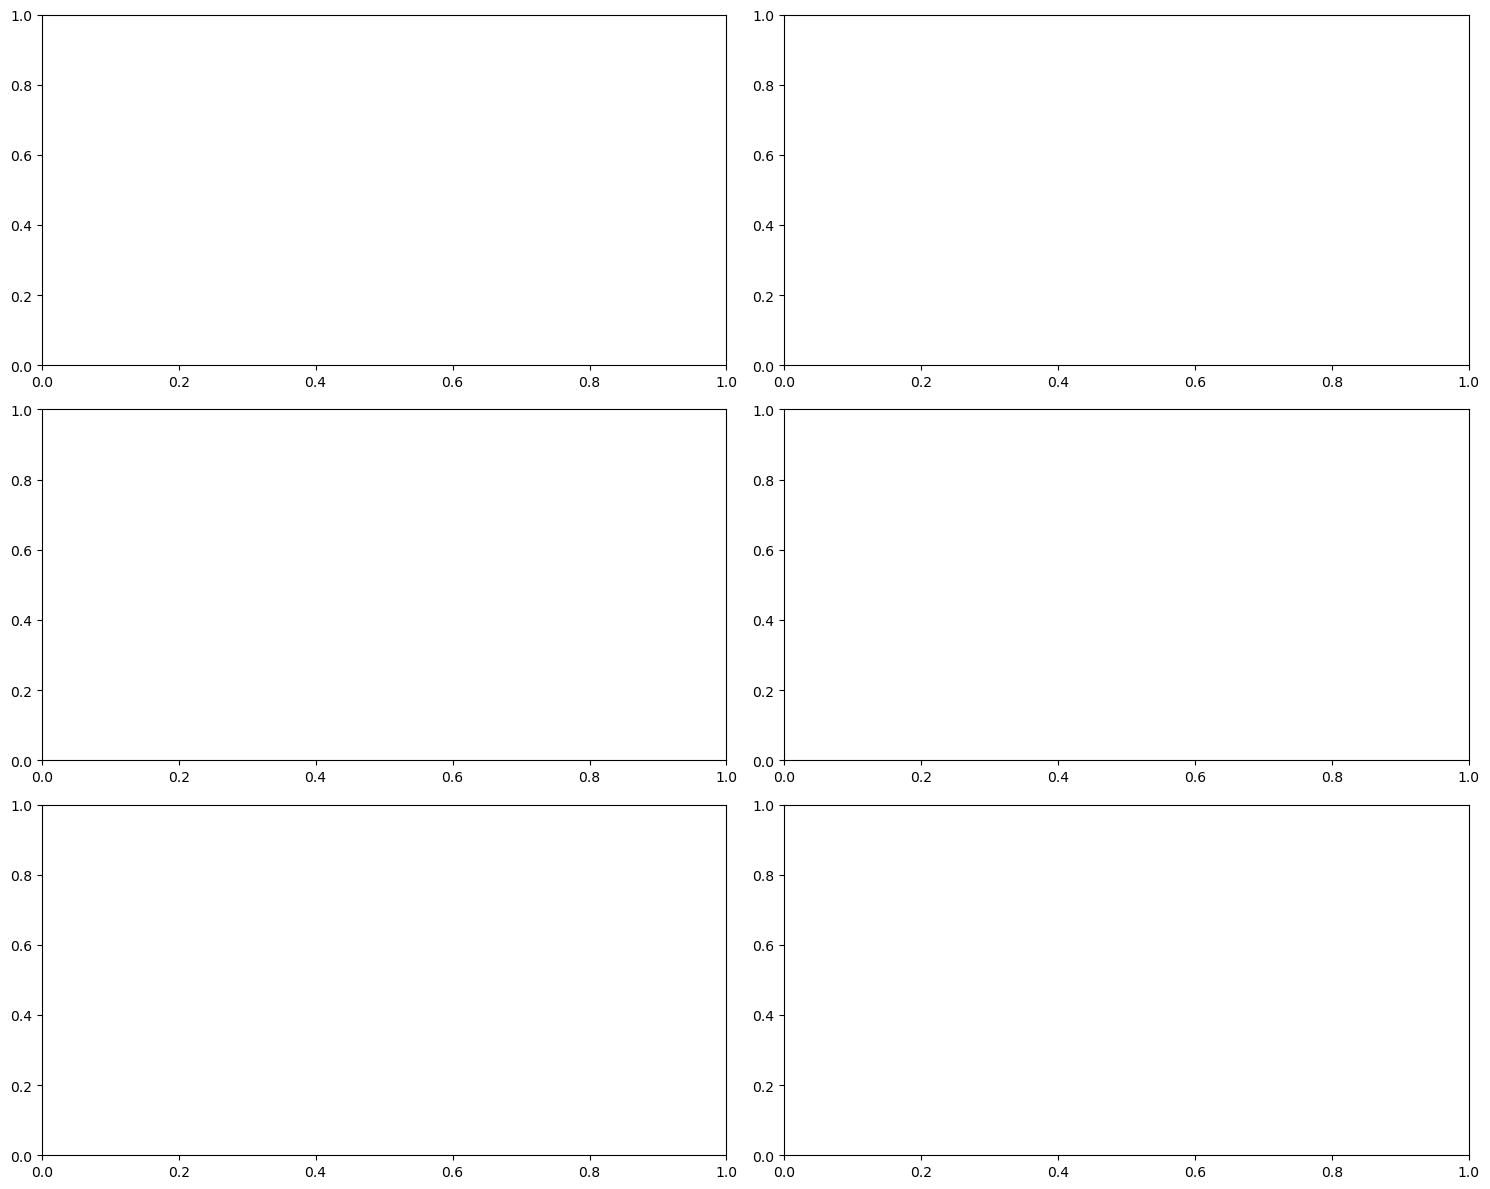

In [11]:

# Configure logging
configure_logging()

full_train_df = load_dataset()
mf = full_train(full_train_df=full_train_df)
forecast_reconciled = generate_forecast(mf=mf, full_train_df=full_train_df)
# LightGBM model parameters
lightgbm_params = LightGBMHP(
    objective="tweedie",
    tweedie_variance_power=1.2,
    n_estimators=1000,
    learning_rate=0.02,
    reg_alpha=1.0,
    reg_lambda=1.0,
    subsample=0.8,
    max_depth=7,
    boost_from_average=False,
)
output_path = save_model_and_forecasts(
    mf=mf,
    forecast_reconciled=forecast_reconciled,
    lightgbm_params=lightgbm_params,
)
forecast_summary_statistics(forecast_reconciled=forecast_reconciled)
visualize_forecasts(
    forecast_reconciled=forecast_reconciled,
    full_train_df=full_train_df,
)
summary_report(
    forecast_reconciled=forecast_reconciled,
    full_train_df=full_train_df,
    FORECAST_HORIZON=FORECAST_HORIZON,
    run=run,
    output_path=output_path,
)